In [2]:
%matplotlib inline

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# OpenJijをimportします。
import openjij as oj

In [4]:
# 反強磁性1次元Ising modelを作ります。
N = 30
h = {0: -10}
J = {(i, i+1): 1 for i in range(N-1)}

In [9]:
# 最適解を作成します。
correct_state = [(-1)**i for i in range(N)]
# 最適値を計算しておきます。
bqm = oj.BinaryQuadraticModel.from_ising(h, J)
minimum_energy = bqm.energy(correct_state)

In [19]:
# TTS を計算するのに必要なpRを定義します。
pR = 0.99

# Samplerの引数の というパラメータに渡すリスト: num_sweeps_listを定義します。
# num_sweepsはアニーリング中のパラメータ(温度, 横磁場)を下げていくときの分割数です。
# よって増やすほどゆっくりアニーリングをすることに相当し、アニーリング時間が伸びます。
num_sweeps_list = [30, 50, 80, 100, 150, 200]

TTS_list = []       # 各計算時間に対するTTSを格納しておくリストを定義します。
tau_list = []        # 計算時間を格納しておくリストを定義します。
e_mean_list = []  # エネルギーの平均値
e_min_list = []    # 最小エネルギー

# 計算の過程で成功確率が求まるので、それを格納しておくリストも定義します。
ps_list = []

In [20]:
# 確率を計算するために1回のアニーリングを行う回数を定義します。
num_reads = 1000

for num_sweeps in num_sweeps_list:
    sampler = oj.SASampler(num_sweeps=num_sweeps, num_reads=num_reads)
    response = sampler.sample_ising(h, J)

    # 計算結果のうち、最適解の数を数えて最適解を得た確率を計算します。
    tau = response.info['execution_time']

    # psを計算します。最適値以下のエネルギーの個数をカウントします。
    energies = response.energies
    ps = len(energies[energies <= minimum_energy])/num_reads + 0.00001


    # ps = 0のときTTSが無限大に発散してしまうため、それを回避します。
    if ps == 0.0:
        continue

    # TTSを計算します。
    TTS_list.append(np.log(1-pR)/np.log(1-ps)*tau if ps < pR else tau)
    tau_list.append(tau)

    # 成功確率を計算します。
    ps_list.append(ps)

    e_mean_list.append(np.mean(energies))
    e_min_list.append(np.min(energies))

Text(0, 0.5, 'Success probability')

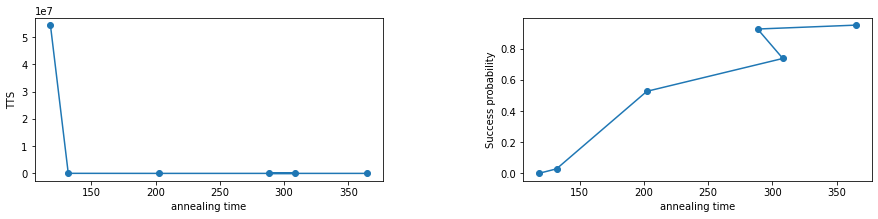

In [24]:
# 各種描画の設定を行います。
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(15,3))
plt.subplots_adjust(wspace=0.4)
fontsize = 10

# TTSを描画します。
axL.plot(tau_list, TTS_list, '-o')
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_ylabel('TTS', fontsize=fontsize)

# 成功確率psを描画します。
axR.plot(tau_list, ps_list, '-o')
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Success probability', fontsize=fontsize)



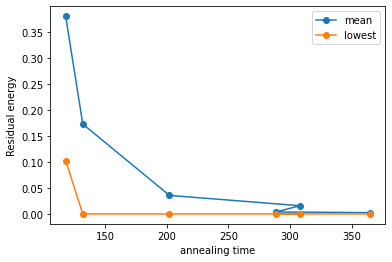

In [25]:
plt.plot(tau_list, (np.array(e_mean_list) - minimum_energy)/np.abs(minimum_energy), '-o', label='mean')
plt.plot(tau_list, (np.array(e_min_list) - minimum_energy)/np.abs(minimum_energy), '-o', label='lowest')
plt.xlabel('annealing time', fontsize=fontsize)
plt.ylabel('Residual energy', fontsize=fontsize)
plt.legend()
plt.show()



In [32]:
# 最適解を定義します。
correct_state = [(-1)**i for i in range(N)]

# num_sweepsとnum_readsの反復数を与えます。
# num_sweeps_list = list(range(10, 51, 10))  # [10, 20, 30, 40, 50]
num_sweeps_list = [30, 50, 80, 100, 150, 200]
num_reads = 1000

# benchmark関数を用いてTTS, 残留エネルギー, 成功確率を計算します。
result = oj.solver_benchmark(
                      solver=lambda time, **args: oj.SASampler(num_sweeps=time, num_reads=num_reads).sample_ising(h,J),
                      time_list=num_sweeps_list, solutions=[correct_state], p_r=0.99
            )

Text(0, 0.5, 'Success probability')

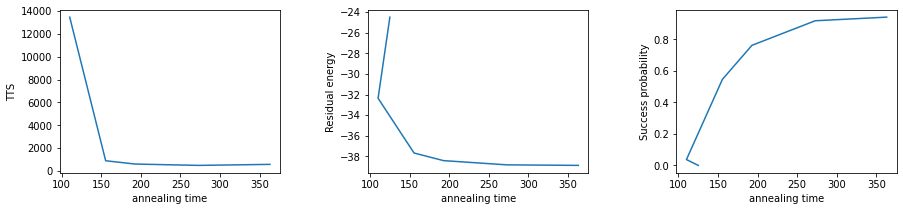

In [33]:
# 各種描画を行うための設定を行います。
fig, (axL,axC,axR) = plt.subplots(ncols=3, figsize=(15,3))
plt.subplots_adjust(wspace=0.4)
fontsize = 10

# TTSを描画します。
axL.plot(result['time'], result['tts'])
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_ylabel('TTS', fontsize=fontsize)

# 残留エネルギーを描画します。
axC.plot(result['time'], result['residual_energy'])
axC.set_xlabel('annealing time', fontsize=fontsize)
axC.set_ylabel('Residual energy', fontsize=fontsize)

# 最適解が出現した確率を描画します。
axR.plot(result['time'], result['success_prob'])
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Success probability', fontsize=fontsize)



In [34]:
import time

def anti_ferro_solver(time_param, num_reads, h, J):
#     """
#     [1, 1, 1,...]と[1,-1,1,...]と[-1,1,-1,...]の3つの状態からランダムに選ぶ関数です。
#     """

    # 入力された h と J から添字の集合を作成します。
    indices = set(h.keys())
    indices = list(indices | set([key for keys in J.keys() for key in keys]))

    # [1, 1, 1,...]の状態を作成します。
    ones_state = list(np.ones(len(indices), dtype=int))

    # [-1, 1, -1,...]の状態を作成します。
    minus_plus_state = np.ones(len(indices), dtype=int)
    minus_plus_state[::2] *= -1
    # [1, -1, 1,...]の状態を作成します。
    plus_minus_state = -1 * minus_plus_state

    # 実行時間を計測を開始します。
    start = time.time()
    _states = [ones_state, list(minus_plus_state), list(plus_minus_state)]

    # 3つの状態からランダムに1つの状態を選出します。
    state_record = [_states[np.random.randint(3)] for _ in range(num_reads)]
    # state_recordをndarrayに変換します。
    state_record = np.array(state_record)

    # ここでは適当に計算時間をかさ増しします。
    exec_time = (time.time()-start) * 10**6 * time_param
    # ここでは適当にエネルギーを計算します。
    energies = [sum(state) for state in state_record]

    # 状態のリストと添字を紐づけるために、1つのタプルにします。
    samples_like = (state_record, indices)

    # dimodのfrom_samplesを参考に、Responseクラスに状態とエネルギーを格納します。
    response = oj.Response.from_samples(samples_like=samples_like, energy=energies, vartype='SPIN')
    # response.infoの'execution_time'キーに計算時間を代入します。
    response.info['execution_time'] = exec_time

    return response

In [35]:
# 最適解である[1, -1, 1,...]を定義しておきます。
correct_state = [(-1)**i for i in range(N)]

# num_sweepsとnum_readsを定義しておきます。
num_sweeps_list = list(range(10, 51, 10))
num_reads = 2000

# benchmark関数でTTS, 残留エネルギー, 成功確率を計算します。
result = oj.solver_benchmark(
                      solver= lambda time_param, **args: anti_ferro_solver(time_param, num_reads, h, J),
                      time_list=num_sweeps_list, solutions=[correct_state], p_r=0.99
              )

Text(0, 0.5, 'Success probability')

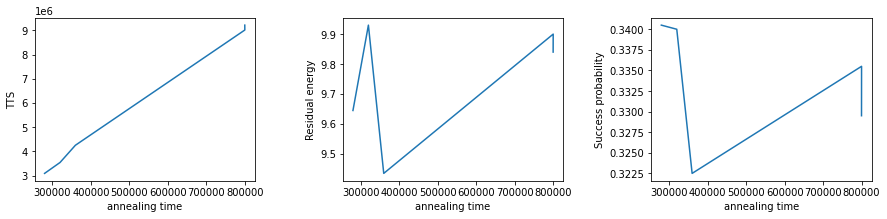

In [36]:
fig, (axL,axC,axR) = plt.subplots(ncols=3, figsize=(15,3))
plt.subplots_adjust(wspace=0.4)

fontsize = 10
axL.plot(result['time'], result['tts'])
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_ylabel('TTS', fontsize=fontsize)

axC.plot(result['time'], result['residual_energy'])
axC.set_xlabel('annealing time', fontsize=fontsize)
axC.set_ylabel('Residual energy', fontsize=fontsize)

axR.plot(result['time'], result['success_prob'])
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Success probability', fontsize=fontsize)